# **Preprocessing the dataframe**

## **Importing libraries**

In [ ]:
! pip install contractions

     |████████████████████████████████| 327kB 9.0MB/s 
     |████████████████████████████████| 245kB 22.2MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp36-cp36m-linux_x86_64.whl size=84336 sha256=4f20aa03d2389dbd756dc62097e2269a7ec21eaed9ad21273afac949713d6a28
  Stored in directory: /root/.cache/pip/wheels/e4/ab/f7/cb39270df8f6126f3dd4c33d302357167086db460968cfc80c
Successfully built pyahocorasick


In [ ]:
# utility libs
from tqdm import tqdm, tqdm_notebook
from time import time
import contractions
import unicodedata

# data handling
import numpy as np
import pandas as pd
import math
import re

# data visualization libs
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# NLP libs
import nltk
from nltk import word_tokenize
from gensim.models import Word2Vec
nltk.download('punkt')

# machine learning libs
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Custom utility functions and objects**

In [ ]:
# function that separates the category variable into three separate variables

def split_cat(text):

    try: return text.split("/")
    except: return ("No label", "No label", "No label")

In [ ]:
# function that expands all the contractions 

def expand_contractions(string):
  
    expanded_words = []  
    for word in string.split(' '): 
        expanded_words.append(contractions.fix(word))    
  
    return ' '.join(expanded_words) 

In [ ]:
# the functions converts accented characters to unicode version

def strip_accents(text):

    try: text = unicode(text, 'utf-8')
    except NameError: pass

    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")

    return str(text)

In [ ]:
# complex function that, given a textual content, ...

def normalize(text):

    text = strip_accents(text)                                              # converts accented characters to unicode format
    text = expand_contractions(str(text))                                   # expands the contractions 
    text = re.sub("\w*\d\w*", repl = '', string=text).strip()               # removes all words containing atleast a number

    norm_string = []
    pattern = r"[^\w\s]"

    for word in re.split(r"[^A-Za-z]+", text.lower()):                      # splits the text with respect to non alphanumeric characters and convers to lower case
        word = re.sub(pattern, repl = '', string=word)                      # removes all non alphanumeric symbols
        word = word.lower()                                                 # converts every word to lower case
        if word not in en_stopwords:                                        # removes all the stopwords
            norm_string.append(word)

    norm_string = list(filter(None, norm_string))                           # filters None strings

    return ' '.join(norm_string)                                            # returns a completely cleaned sentence if atleast one word is left

In [ ]:
# function that iterates over a corpus of tokens per sentence and extracts every unique term

def build_vocab(corpus_tokens):

    vocab = set({})
    for tokens in corpus_tokens:
        for token in tokens:
            vocab.add(token)
          
    return list(vocab)

In [ ]:
# definition of custom stop words list

en_stopwords = ["the", "a", "an", "i", "you", "he", "she", "it", "we", "they", "my", "your", "his", "her", "its", "our", "their", "mine", "yours", "hers", "ours", "theirs",
                "me", "him", "her", "it", "us", "them", "this", "that", "those", "these", "myself", "yourself", "himself", "herself", "ourselves", "yourselves", "themselves", "itself",
                "which", "who", "what", "when", "why", "whom", "where", "how", "on", "in", "at", "since", "for", "ago", "before", "to", "till", "untill", "by", "in", "on", "under",
                "below", "over", "across", "above" "ago", "through", "onto", "from", "into", "of", "off", "about", "at", "some", "any", "and", "but", "or", "yet", "so", "although", "though",
                "while", "if", "after", "because", "since", "than", "whether", "either", "neither", "both", "also", "with", "between", "against", "during", "down", "out", "further", "there", 
                "each", "few", "more", "most", "other", "such", "only", "same", "too", "very", "s", "t", "just", "now", "up", "then", "here", "even", "back", "still", "as", "back", "about", "anyway", "somehow",
                "however", "almost", "much", "later", "around", "already", "maybe", "perhaps", "less", "either", "early", "soon", "quite", "thus", "forward", "backward", "rather", "indeed", "ahead"]

## **Load Datasets**

In [ ]:
from google.colab import drive  
drive.mount("/content/drive", force_remount = True)
!unzip '/content/drive/MyDrive/AML/AML-materiale.zip' -d '/content/'

Mounted at /content/drive
Archive:  /content/drive/MyDrive/AML/AML-materiale.zip
replace /content/test.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: /content/test.tsv       
replace /content/train.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: /content/train.tsv      A



In [ ]:
dir = '/content/drive/MyDrive/AML/'

In [ ]:
x_train = pd.read_table("/content/train.tsv")
x_test = pd.read_table("/content/test.tsv")
x_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


## **Preprocessing**

#### **Working on the data**

The very first step is to clean the data from NaN values and getting rid of unwanted data (like the *train_id* and *test_id* columns).

In [ ]:
x_train.drop(columns='train_id', inplace=True)
x_test.drop(columns='test_id', inplace=True)

Every instance in the dataset cointaining atleast one NaN value is dropped so as to be able to exploit every variable's information.

In [ ]:
pd.concat([(x_train.isnull().sum()/len((x_train))).to_frame().rename(columns = {0:'perc_missing'}), pd.Series(x_train.isnull().sum())], axis=1).rename(columns={0:'count'})

,perc_missing,count
name,0.000000,0
item_condition_id,0.000000,0
category_name,0.004268,6327
brand_name,0.426757,632682
price,0.000000,0
shipping,0.000000,0
item_description,0.000003,4


In [ ]:
pd.concat([(x_test.isnull().sum()/len((x_test))).to_frame().rename(columns = {0:'perc_missing'}), pd.Series(x_test.isnull().sum())], axis=1).rename(columns={0:'count'})

,perc_missing,count
name,0.000000,0
item_condition_id,0.000000,0
category_name,0.004410,3058
brand_name,0.426222,295525
shipping,0.000000,0
item_description,0.000000,0


The majority of NaNs values (around ~43%) is present in *brand_name* variable.<br> Since the brand is a very important feature in predicting the price, we decide to remove those observations.

In [ ]:
x_train.dropna(inplace = True)
x_test.dropna(inplace = True)

print('Train dataset final length:',len(x_train))
print('Test dataset final length:', len(x_test))

Train dataset final length: 846982
Test dataset final length: 396431


By inspecting our datasets we discover that some observations regarding the item description are just random numbers without any meaning.<br> These bring no really useful information and are eventually removed.

In [ ]:
x_train[x_train.item_description.str.isnumeric() == True].head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
9101,2 half zips bundle,3,Women/Athletic Apparel/Jackets,Victoria's Secret,46.0,0,2
51575,Fancy Nancy Lip Gloss,1,Beauty/Makeup/Lips,Mary Kay,10.0,1,047935
78704,LeBron James Bobblehead,2,Vintage & Collectibles/Collectibles/Figurine,NBA,18.0,0,2009
106081,Vs tease rollerball perfume,1,Beauty/Fragrance/Women,Victoria's Secret,13.0,0,1
189566,Ultimate alliance 2,3,Electronics/Video Games & Consoles/Games,Sony,8.0,1,2


In [ ]:
print('Numeric-only item descriptions in the train set:', len(x_train[x_train.item_description.str.isnumeric() == True]))
print('Numeric-only item descriptions in the test set:', len(x_test[x_test.item_description.str.isnumeric() == True]))

Numeric-only item descriptions in the train set: 35
Numeric-only item descriptions in the test set: 25


In [ ]:
# deleting strings where item_description is numeric
x_train = x_train[x_train.item_description.str.isnumeric() != True].reset_index(drop=True)
x_test = x_test[x_test.item_description.str.isnumeric() != True].reset_index(drop=True)

Then, every *category_name* instance has been split into three different variables using "\/" as separator, eventually dropping the original variable.

In [ ]:
x_train['general_cat'], x_train['subcat_1'], x_train['subcat_2'] = zip(*x_train['category_name'].apply(lambda x: split_cat(x)))
x_train.drop('category_name',1,inplace=True)

x_test['general_cat'], x_test['subcat_1'], x_test['subcat_2'] = zip(*x_test['category_name'].apply(lambda x: split_cat(x)))
x_test.drop('category_name',1, inplace=True)

In [ ]:
for i, string in enumerate(x_train.item_description):
  if "_______________" in str(string):
    print(i, string)

1697 MENS SIZE: medium ______________________________________ FEATURES: Condition: Brand New Tags (NEVER USED OR WORN) Patch: Yes Logo: Embroidery Authentic: YES ________________________________________ Hi there! Alfomart is Top rated sellers in: ☆Customer service :-) & Easy returns ☆FAST N FREE shipping! ☆Excellent Quality ♡♡ Checkout our page and follow us for updates & see what our customers are saying. Thank you for stopping by! :) ________________________________________ SHIPPING: ●Ships out in 1 Business day. ●Delivery time is 2-4 business days depending on your location. ________________________________________ Tags: #futol #soccer #fifa #football #jersey #shirt #tshirt #mens #tops #sports #player #Authentic #player #fans #team sports #Sporting goods #sports #2016/17 #16/17 #2016 #2017 #new #with tag # Patch #
3189 MENS SIZE: SMALL ______________________________________ FEATURES: Condition: Brand New Tags (NEVER USED OR WORN) Patch: Yes Logo: Embroidery Authentic: YES __________

In [ ]:
le = LabelEncoder()

le.fit(np.hstack([x_train.general_cat, x_train.subcat_1, x_train.subcat_2, x_test.general_cat, x_test.subcat_1, x_test.subcat_2]))

x_train.general_cat = le.transform(x_train.general_cat)
x_train.subcat_1 = le.transform(x_train.subcat_1)
x_train.subcat_2 = le.transform(x_train.subcat_2)

x_test.general_cat = le.transform(x_test.general_cat)
x_test.subcat_1 = le.transform(x_test.subcat_1)
x_test.subcat_2 = le.transform(x_test.subcat_2)

le.fit(np.hstack([x_train.brand_name, x_test.brand_name]))

x_train.brand_name = le.transform(x_train.brand_name)
x_test.brand_name = le.transform(x_test.brand_name)
del le

x_train.head()

,name,item_condition_id,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,Razer BlackWidow Chroma Keyboard,3,3876,52.0,0,This keyboard is in great condition and works ...,249,189,188
1,AVA-VIV Blouse,1,4572,10.0,1,Adorable top with a hint of lace and a key hol...,752,683,80
2,Acacia pacific tides santorini top,3,84,64.0,0,Size small but straps slightly shortened to fi...,752,652,715
3,Girls cheer and tumbling bundle of 7,3,4326,6.0,1,You get three pairs of Sophie cheer shorts siz...,619,17,301
4,Girls Nike Pro shorts,3,3325,19.0,0,Girls Size small Plus green. Three shorts total.,619,17,301


In [ ]:
# analysing the target variable
x_train.price.describe()

count    846947.000000
mean         30.918416
std          44.743650
min           0.000000
25%          12.000000
50%          20.000000
75%          34.000000
max        2009.000000
Name: price, dtype: float64

The target variable ranges from 0 to 2009.<br> Actually, as the goal is to predict a price having prices all over a set of items, items having price equal to 0$ are not realistic and not really considerable while training our model.

In [ ]:
x_train = x_train[x_train.price > 0].reset_index(drop=True)

#### **Sentences tokenization**

Using the utility function *normalize* the text is initially transformed into a "standard" form having no contractions, only lower cases letters and no alphanumeric symbols.

In [ ]:
tqdm.pandas()

item_description_train = x_train['item_description'].progress_apply(normalize)
item_description_test = x_test['item_description'].progress_apply(normalize)

item_description_tokens_train = item_description_train.progress_apply(word_tokenize)
item_description_tokens_test = item_description_test.progress_apply(word_tokenize)

100%|██████████| 396406/396406 [01:07<00:00, 5870.22it/s]


In [ ]:
name_train = x_train['name'].progress_apply(normalize)
name_test = x_test['name'].progress_apply(normalize)

name_tokens_train = name_train.progress_apply(word_tokenize)
name_tokens_test = name_test.progress_apply(word_tokenize)

100%|██████████| 396406/396406 [00:41<00:00, 9555.24it/s]


In this way, we have perfectly cleaned and clear tokens.

In [ ]:
print(type(item_description_train), '\n')
item_description_train

<class 'pandas.core.series.Series'> 



0         keyboard is great condition works like came bo...
1         adorable top hint lace key hole pale pink is h...
2         size small straps slightly shortened fit xs be...
3         get three pairs sophie cheer shorts size small...
4            girls size small plus green three shorts total
                                ...                        
846421    removable straps make strapless size b perfect...
846422    purple paisley victoria secret tankini size la...
846423    rm set perfect condition no holes stains like ...
846424    lace says size small fits medium perfectly nev...
846425        little mermaid handmade dress never worn size
Name: item_description, Length: 846426, dtype: object

#### **Building the vocabulary**

In [ ]:
len(name_tokens_train.tolist() + item_description_tokens_train.tolist())

1692852

In [ ]:
index_to_word = build_vocab(name_tokens_train.tolist() + item_description_tokens_train.tolist())

In [ ]:
len(index_to_word)

101154

In [ ]:
word_to_index = dict([i, word] for word, i in enumerate(index_to_word))

#### **Mapping words to embeddings**

Common applications suggest that mapping to 300 embeddings carries out good results.

In [ ]:
item_description_tokens_train.map(len).describe()

count    846426.000000
mean         16.154467
std          16.985715
min           0.000000
25%           6.000000
50%          11.000000
75%          20.000000
max         153.000000
Name: item_description, dtype: float64

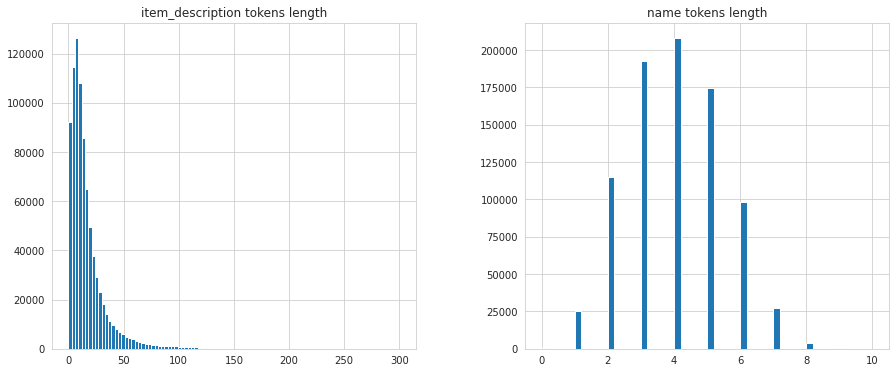

In [ ]:
with sns.axes_style("whitegrid"):
  fig, axs = plt.subplots(1, 2, figsize = (15, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
  (ax1, ax2) = axs

  ax1.hist(item_description_tokens_train.map(len), bins = 100, range = [0, 300])
  ax1.set_title('item_description tokens length')

  ax2.hist(name_tokens_train.map(len), bins = 50, range = [0, 10])
  ax2.set_title('name tokens length')

plt.show()

In [ ]:
for quantile in list(np.linspace(0, 1, num=11)):
  print("quantile: {}% ------>  tokens lists length: {}".format(int(round(quantile*100, 2)), int(item_description_tokens_train.map(len).quantile(quantile))))

quantile: 0% ------>  tokens lists length: 0
quantile: 10% ------>  tokens lists length: 2
quantile: 20% ------>  tokens lists length: 5
quantile: 30% ------>  tokens lists length: 7
quantile: 40% ------>  tokens lists length: 9
quantile: 50% ------>  tokens lists length: 11
quantile: 60% ------>  tokens lists length: 14
quantile: 70% ------>  tokens lists length: 18
quantile: 80% ------>  tokens lists length: 23
quantile: 90% ------>  tokens lists length: 35
quantile: 100% ------>  tokens lists length: 153


In [ ]:
name_tokens_train.map(len).describe()

count    846426.000000
mean          3.965721
std           1.449959
min           0.000000
25%           3.000000
50%           4.000000
75%           5.000000
max          11.000000
Name: name, dtype: float64

In [ ]:
start_at = time()
word2vec = Word2Vec(item_description_tokens_train, size=300, min_count=2, iter=10)
print(type(word2vec))
print('Tempo di esecuzione:', time()-start_at)

<class 'gensim.models.word2vec.Word2Vec'>
Tempo di esecuzione: 290.36724495887756


In the cell below we can see how Word2Vec definitely managed to capture semantic similarity.

In [ ]:
word2vec.most_similar('pokemon', topn = 10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('pikachu', 0.5984276533126831),
 ('squirtle', 0.5818403363227844),
 ('charizard', 0.576256513595581),
 ('pokeball', 0.5610876083374023),
 ('heartgold', 0.5489881634712219),
 ('jigglypuff', 0.5412645936012268),
 ('bulbasaur', 0.5363326072692871),
 ('charmander', 0.5313969850540161),
 ('firered', 0.5137810707092285),
 ('blastoise', 0.5094032287597656)]

#### **Normalising the numeric variables**

The last step is bringing every numeric variable to a standard scale to reduce the impact of outliers.<br>In this case, the only <u>truly</u> numeric variable (non binary, non indexing) is indeed *price*.

In [ ]:
x_train.price.describe()

count    846426.000000
mean         30.937447
std          44.750840
min           3.000000
25%          12.000000
50%          20.000000
75%          34.000000
max        2009.000000
Name: price, dtype: float64

In [ ]:
x_train.price = np.log(x_train.price)

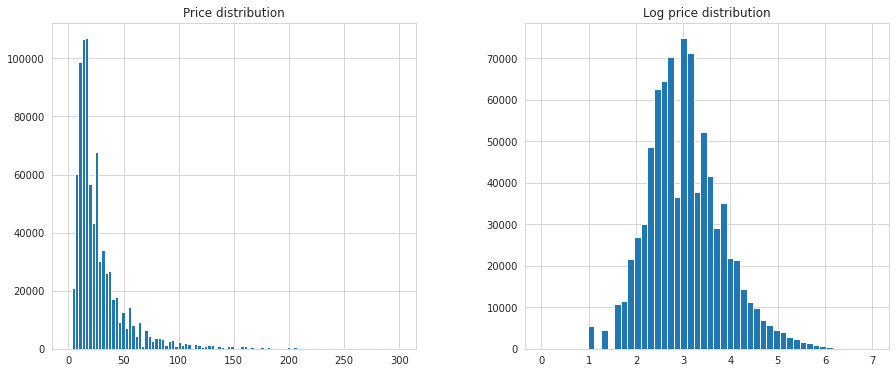

In [ ]:
with sns.axes_style("whitegrid"):
  fig, axs = plt.subplots(1, 2, figsize = (15, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
  (ax1, ax2) = axs

  ax1.hist(np.exp(x_train.price), bins = 100, range = [0, 300])
  ax1.set_title('Price distribution')

  ax2.hist(x_train.price, bins = 50, range = [0, 7])
  ax2.set_title('Log price distribution')

plt.show()

## **Exporting the data**

In [ ]:
x_train.name = name_train
x_train.item_description = item_description_train
x_train.head()

,name,item_condition_id,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,razer blackwidow chroma keyboard,3,3876,3.951244,0,keyboard is great condition works like came bo...,249,189,188
1,ava viv blouse,1,4572,2.302585,1,adorable top hint lace key hole pale pink is h...,752,683,80
2,acacia pacific tides santorini top,3,84,4.158883,0,size small straps slightly shortened fit xs be...,752,652,715
3,girls cheer tumbling bundle,3,4326,1.791759,1,get three pairs sophie cheer shorts size small...,619,17,301
4,girls nike pro shorts,3,3325,2.944439,0,girls size small plus green three shorts total,619,17,301


In [ ]:
x_test.name = name_test
x_test.item_description = item_description_test
x_test.head()

,name,item_condition_id,brand_name,shipping,item_description,general_cat,subcat_1,subcat_2
0,coach bag,1,1090,1,brand new coach bag bought rm coach outlet,731,42,324
1,vintage cameo pendant brooch pin,3,4945,1,two vintage cameo pieces silver metal locket p...,752,378,467
2,daisy marc jacobs,3,2889,0,brand new no box authentic firm price no offers,65,282,752
3,tuff jeans cowgirl tuff co,3,1182,0,waist length decorated copper silver hardware ...,752,376,90
4,lululemon crop size,3,2862,0,super soft cropped sweat pant good condition n...,752,27,499


In [ ]:
print('Train set has %s rows, test set has %s rows.' % (len(x_train), len(x_test)))

Train set has 846426 rows, test set has 396406 rows.


The application of normalize function might have completely removed some textual strings. It might be needed to remove these rows aswell since they carry no more information to use to train the model and might be produce utter NaNs when exported to xlsx file.

In [ ]:
x_train[x_train.name == ''].head()

,name,item_condition_id,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
1303,,1,3325,3.401197,0,vs pink water bottles bag,619,252,269
1801,,3,3337,2.708050,1,no description,249,728,294
4634,,3,4345,2.197225,0,make offer do not want,249,728,294
4709,,3,922,1.791759,1,great condition pokadot has minor wash wear li...,384,303,684
5471,,3,4345,4.430817,0,comes all games controller system all working ...,731,249,727


In [ ]:
x_train = x_train[(x_train.name != '') & (x_train.item_description != '')].reset_index(drop=True)
x_test = x_test[(x_test.name != '') & (x_test.item_description != '')].reset_index(drop=True)

In [ ]:
print('Eventually, the train set has %s rows and the test set %s rows.' % (len(x_train), len(x_test)))

Eventually, the train set has 844805 rows and the test set 395678 rows.


Now the datasets are ready to be exported.

In [ ]:
x_train.to_csv(dir+'x_train2.csv')
x_test.to_csv(dir+'x_test2.csv')